In [139]:
import pyodbc
import pandas as pd

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

Case_Query = '''
select *
from [dbo].[pds_CaseMeetings]
where [MeetingType] <> '' and [MeetingType] <> 'Other' and year([MeetingDate]) > '1951' 
  '''
# save the sql query to a pandas dataframe
Case_Data = pd.read_sql(Case_Query, connection)
connection.close()

Case_Data['MeetingDate'] = pd.to_datetime(Case_Data['MeetingDate']) #converte MeetingDate to datetime format
Case_Data['MeetingDate'] = Case_Data['MeetingDate'].dt.year #converte MeetingDate to year
Case_Data.head(10)

,meeting_id,case_id,CaseNumber,MeetingType,MeetingDate,Result,Vote
0,7571,20987,4-UP-2001,City Council Hearing,2001,APPROVED,7-0
1,7573,20988,5-UP-2001,Planning Commission Hearing,2001,CONTINUED,
2,7574,20988,5-UP-2001,City Council Hearing,2001,APPROVED,7-0
3,7575,20990,3-ZN-2001,Planning Commission Hearing,2001,CONTINUED,6-0
4,7576,20990,3-ZN-2001,City Council Hearing,2001,APPROVED,7-0
5,7578,20911,77-SD-1984,Remote Hearing,2001,APPROVED,
6,7579,20994,12-DR-2001,Development Review Hearing,2001,CONTINUED,
7,7580,20996,13-DR-2001,Development Review Hearing,2001,APPROVED,6-0
8,7581,20995,6-UP-2001,Planning Commission Hearing,2001,CONTINUED,
9,7582,20995,6-UP-2001,City Council Hearing,2001,APPROVED,4-3


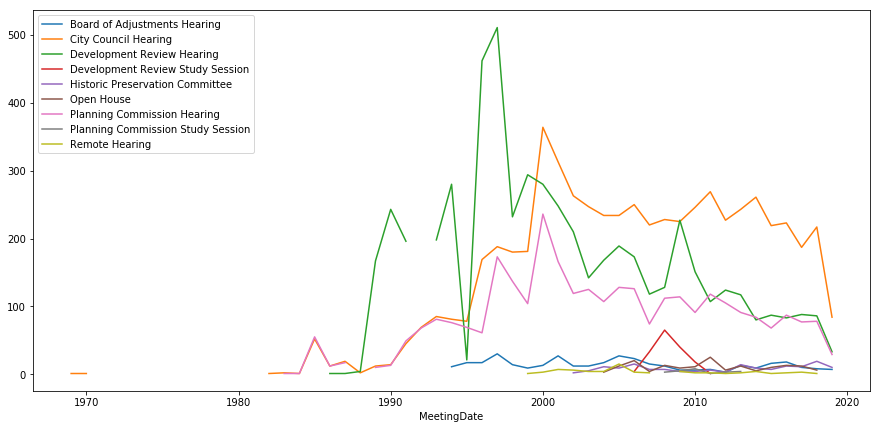

In [137]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
Case_Data.groupby(['MeetingDate','MeetingType']).count()['meeting_id'].unstack().plot(ax=ax)
plt.legend(loc='upper left')

In [132]:
Sorted = Case_Data.sort_values(by=['Opposition_Score'],ascending=False)
Sorted.head(10)

,meeting_id,case_id,CaseNumber,MeetingType,MeetingDate,Result,Vote,For_Vote,Against_Vote,Opposition_Score
11544,12573,24545,102-LL-2002,City Council Hearing,2003,DENIED,0-6,0.0,6.0,inf
3155,10718,22922,2-UP-2002,Planning Commission Hearing,2002,DENIED,1-4,1.0,4.0,4.000000
10787,24882,28012,28-UP-2004,City Council Hearing,2006,DENIED,2-5,2.0,5.0,2.500000
10068,8660,6378,29-ZN-1993,Planning Commission Hearing,1993,DENIED,2-4,2.0,4.0,2.000000
685,48408,45637,60-DR-2015,Development Review Hearing,2016,DENIED,2-4,2.0,4.0,2.000000
11737,22175,29214,4-BA-2005,Board of Adjustments Hearing,2005,DENIED,3-4,3.0,4.0,1.333333
9981,8565,16100,71-ZN-1994,City Council Hearing,1995,DENIED,3-4,3.0,4.0,1.333333
919,46707,43757,6-TA-2014,City Council Hearing,2015,DENIED,3-4,3.0,4.0,1.333333
14262,37841,39548,1-II-2010#2,City Council Hearing,2011,DENIED,3-4,3.0,4.0,1.333333
2667,46296,44530,1-ZN-2015,City Council Hearing,2015,DENIED,3-4,3.0,4.0,1.333333


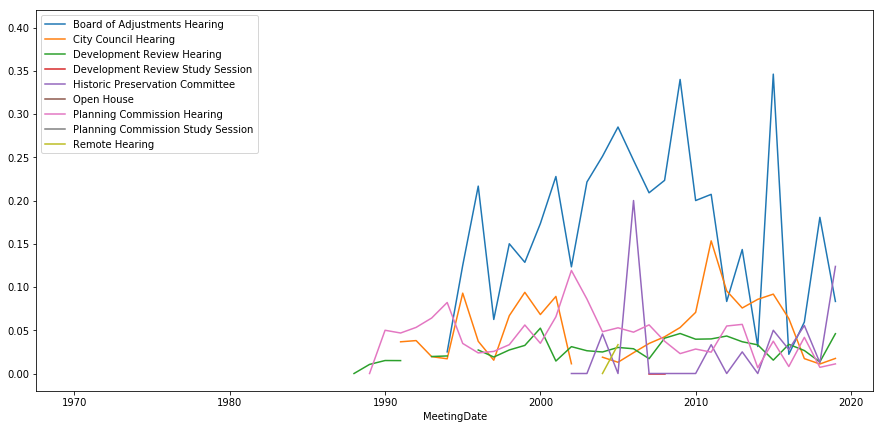

In [136]:
#clean data and form attributes
Case_Data['Vote'] = Case_Data['Vote'].str.replace(' ','') #remove leading and trailing white spaces
Case_Data['For_Vote'] = Case_Data['Vote'].str[0].apply(pd.to_numeric, args=('coerce',)) #extract 'for' votes, convert to numeric
Case_Data['Against_Vote'] = Case_Data['Vote'].str[2].apply(pd.to_numeric, args=('coerce',)) #extract 'against' votes, convert to numeric
Case_Data['Opposition_Score'] = Case_Data['Against_Vote']/Case_Data['For_Vote'] # divide 'against' votes by 'for' votes
# Case_Data.info()
 
#plot
fig, ax = plt.subplots(figsize=(15,7))
Case_Data.groupby(['MeetingDate','MeetingType']).mean()['Opposition_Score'].unstack().plot(ax=ax)
plt.legend(loc='upper left')